In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import umap

from tqdm import tqdm

import ipywidgets as widgets
from src.models import ContextSpaceNet, OldSpaceNet

# %matplotlib notebook
%matplotlib inline

In [22]:
class ContextSpaceNet1(OldSpaceNet):

    def context_loss(self, x):
        pass

    def loss_fn(self, x, y):
        """Loss function

        Args:
            inputs: Torch tensor of shape (batch size, 3). The function assumes
            that the first two components are spatial coordinates, while
            the last is a context coordinate.

        Returns:
            loss (1D tensor)
        """
        corr = self(x)
        label_space = self.correlation_function(y[:, :-1])

        label_context = self.correlation_function(y[:, -1, None])
        # label_corr = label_space + label_context
        loss = torch.mean((corr - label_space) ** 2)
        return loss

In [10]:
train_steps = 10000

n_in = 3 # 2 position + 1 context
n_out = 100 # no. of spatial representations
bs = 512 # batch size

# model = ContextSpaceNet(n_in, n_out)
model = ContextSpaceNet1(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 3)), dtype= torch.float32)
    c = torch.tensor(np.random.uniform(-2, 2, bs), dtype = torch.float32)
    inputs = torch.cat((r, c[:,None]), dim = -1)
    inputs = r
    loss = model.train_step(x = inputs, y = inputs, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000040: 100%|██████████| 10000/10000 [01:02<00:00, 159.43it/s]


Text(0, 0.5, 'Train Loss')

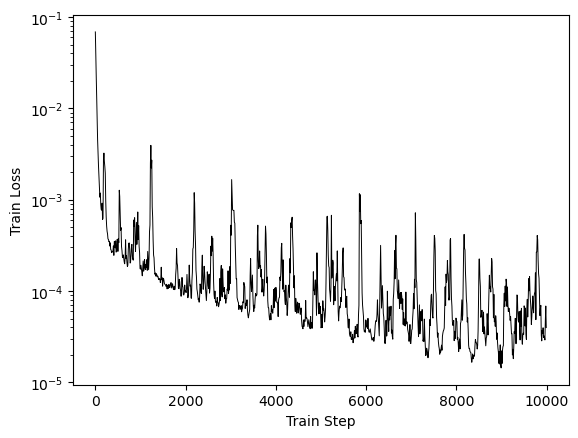

In [11]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [12]:
# evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

In [13]:
n_show = 5   # show ratemaps for first n_show nodes
cols = np.linspace(0,1, n_out)

def f(c):
    fig, ax = plt.subplots(n_show, n_show, figsize = (5, 5))
    context = c*torch.tensor(np.ones(len(u)), dtype = torch.float32)
    inputs = torch.cat((u, context[...,None]), dim = -1)
    p = model.spatial_representation(inputs)
    p = p.detach().numpy()

    max_ind = np.argmax(p, axis = 0)
    max_loc = u[max_ind]

    mask = np.mean(p, axis = 0) > 0 # mask out active units
    ax[0,0].set_title(f"Non-zero units: {mask.sum()}")

    ax[0,0].scatter(*max_loc.T, c = cols, cmap = "jet")
    ax[0,0].axis([-2, 2, -2, 2])
    ax[0,0].set_aspect("equal")

    count = 0
    for i in range(n_show):
        for j in range(n_show):
            if (i == 0) and (j == 0):
                pass
            else:
                ax[i,j].imshow(p[:,count].reshape((n,n)), cmap = "jet")
                ax[i,j].axis("off")
                count += 1
    plt.show()

c_slider = widgets.FloatSlider(
    value=0,
    min=-3.0,
    max=3.0,
    step=0.01,
    description='c:',
    readout_format='.2f')

widgets.interactive(f, c = c_slider)

interactive(children=(FloatSlider(value=0.0, description='c:', max=3.0, min=-3.0, step=0.01), Output()), _dom_…

Create input data

In [14]:
x = np.arange(-1, 1, 0.05)
y = x.copy()
c = np.arange(-1, 1, 0.05)
xx, yy, cc = np.meshgrid(x, y, c)

In [15]:
u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), cc.ravel()], axis=-1), dtype=torch.float32)

Get model output

In [16]:
sr = model.spatial_representation(u)
sr = sr.detach().numpy()

Run UMAP

In [17]:
fit = umap.UMAP(n_components=3)
umap_sr = fit.fit_transform(sr)

3D plots for context, x, and y dimensions

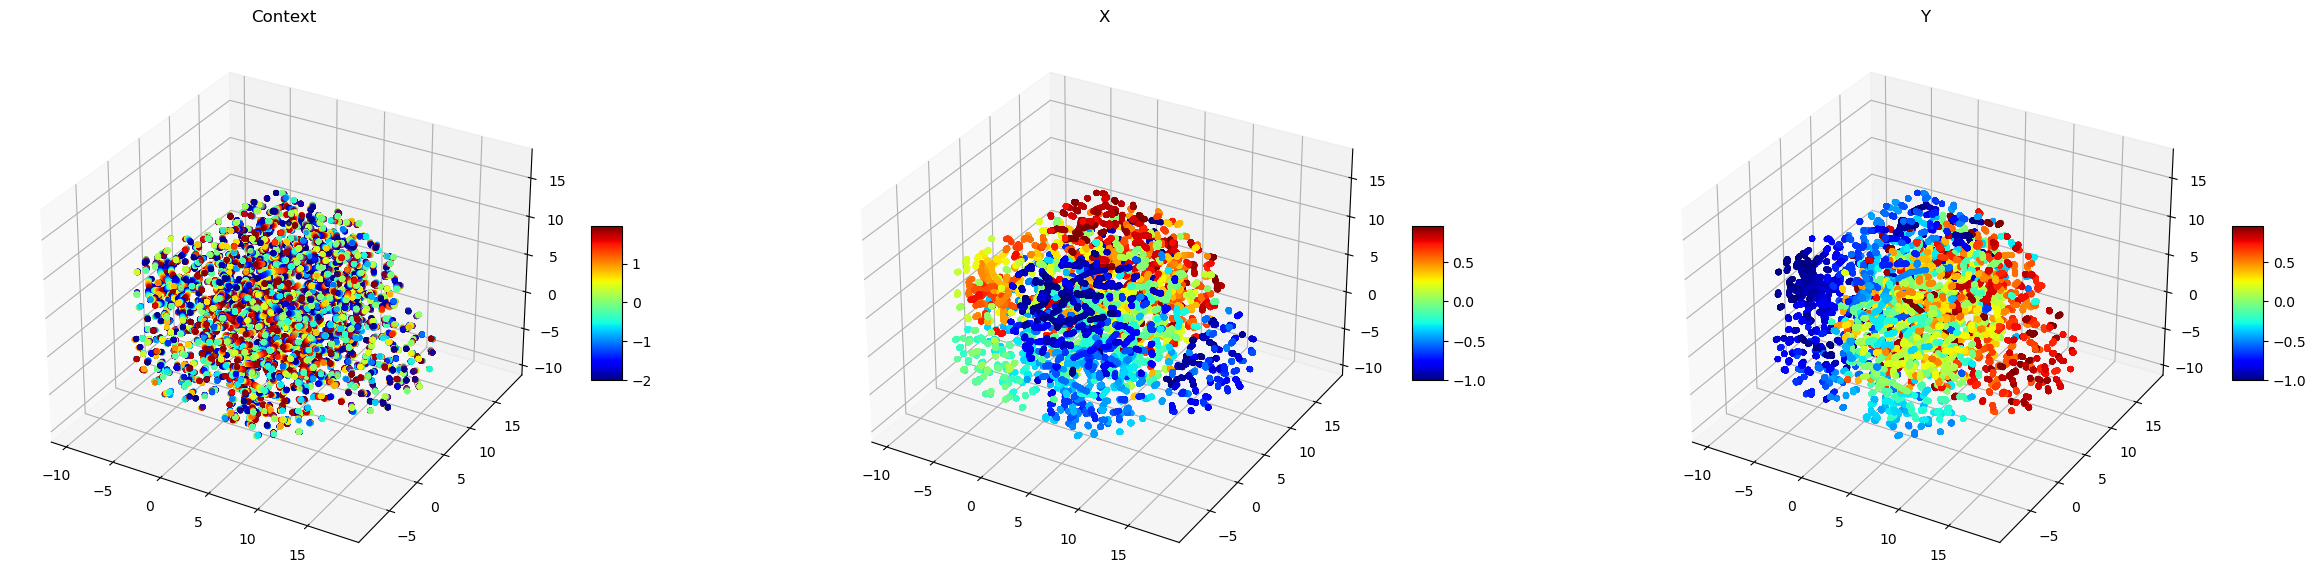

In [18]:
fig = plt.figure(figsize=(30, 10))

# Context dimension
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(umap_sr[:, 0], umap_sr[:, 1], umap_sr[:, 2], s=10, c=cc.ravel(), cmap='jet')
ax.set_title("Context")
fig.colorbar(p, shrink=0.2, aspect=5)

# X dimension
ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(umap_sr[:, 0], umap_sr[:, 1], umap_sr[:, 2], s=10, c=xx.ravel(), cmap='jet')
ax.set_title("X")
fig.colorbar(p, shrink=0.2, aspect=5)

# Y dimension
ax = fig.add_subplot(133, projection='3d')
p = ax.scatter(umap_sr[:, 0], umap_sr[:, 1], umap_sr[:, 2], s=10, c=yy.ravel(), cmap='jet')
ax.set_title("Y")
fig.colorbar(p, shrink=0.2, aspect=5)

Find max location for each unit and context

In [19]:
max_locations = np.zeros((c.shape[0], sr.shape[-1], 2))      # (n_contexts, n_units, x/y)
xyc = np.stack([xx.ravel(), yy.ravel(), cc.ravel()], axis=-1)
cc = cc.ravel()

# Iterate over all contexts
for i, _c in enumerate(c):

    # Get the argmax of the spatial representation for this context
    a = np.argmax(sr[cc == _c, :], axis=0)

    # Find inactive units
    mask = np.mean(sr[cc == _c, :], axis=0) > 0

    # Save the x, y coordinate of the max location for each unit
    max_locations[i, :, :] = xyc[cc == _c][a, :2]

    # Set inactive units to NaN
    max_locations[i, ~mask] = np.nan

non_zero_units = np.argwhere(np.mean(sr, axis=0) > 0).squeeze()

Create 3D plot of max locations for each unit (one line) over contexts (z-axis)

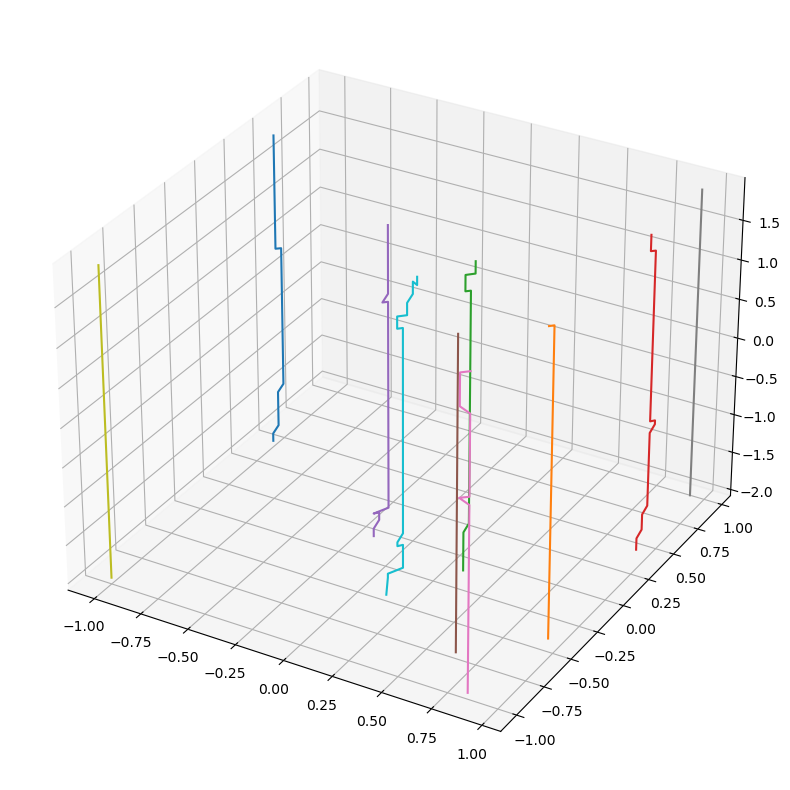

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for n in range(10):
    ax.plot(max_locations[:, non_zero_units[n], 0], max_locations[:, non_zero_units[n], 1], c)
fig.colorbar(p, shrink=0.2, aspect=5)
plt.show()

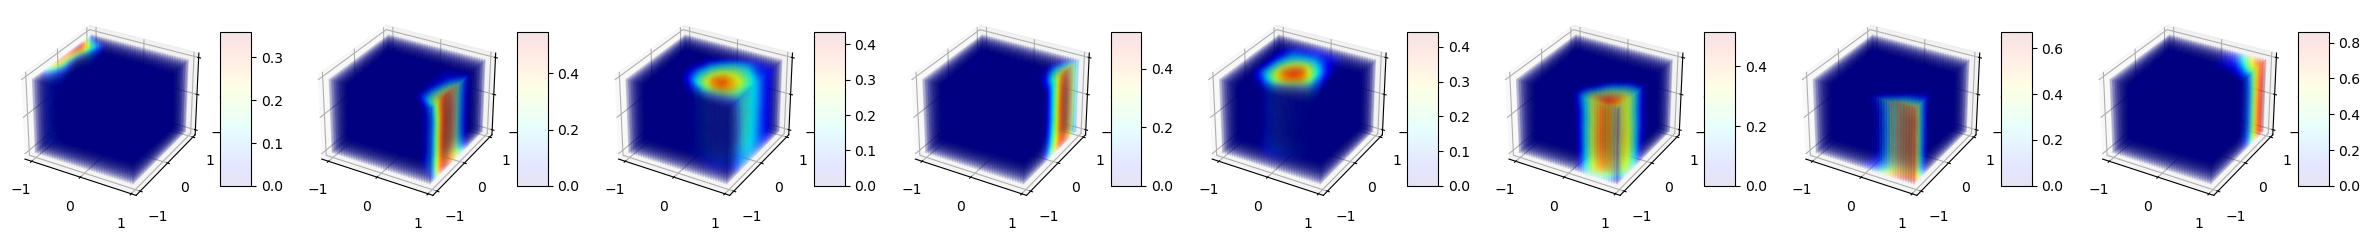

In [21]:
n_units = 8

fig = plt.figure(figsize=(30, 10))
for i in range(n_units):
    idx = non_zero_units[i]
    ax = fig.add_subplot(1, n_units, i+1, projection='3d')
    p = ax.scatter(xx, yy, cc, c=sr[:, idx], cmap='jet', s=0.5, alpha=0.1)
    fig.colorbar(p, shrink=0.2, aspect=5)
plt.show()

/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_70201/218121709.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_70201/218121709.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(coords.min(axis=0)[0], coords.max(axis=0)[0])
/var/folders/mr/n5s35q7j47n7wf8c1z8zzv280000gn/T/ipykernel_70201/218121709.py:33: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(coords.min(axis=0)[1], coords.max(axis=0)[1])


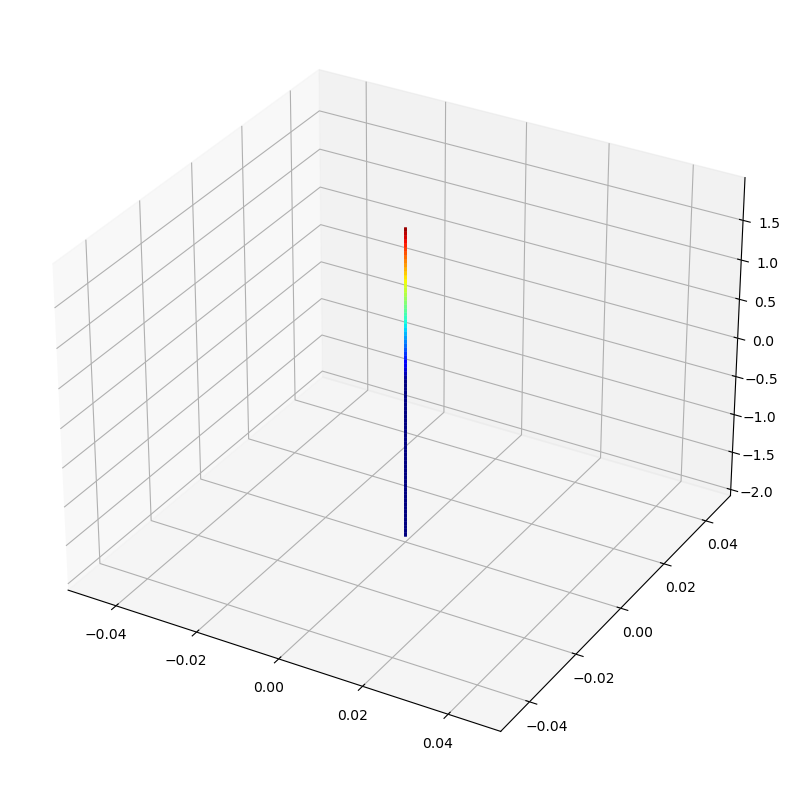

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.cm as cm


# Create a color map based on the values
cmap = cm.get_cmap('jet')
colors = cmap(c / (c.max()))

# Plot the colored line in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for n in [3, 5]:

    # Create coords
    coords = np.stack([max_locations[:, n, 0], max_locations[:, n, 1], c], axis=-1)

    coords[np.isnan(coords)] = 0

    # Create 3D line segments
    segments = np.array([coords[:-1], coords[1:]]).transpose(1, 0, 2)

    # Create a Line3DCollection with the segments and colors
    lc = Line3DCollection(segments, colors=colors, linewidth=2)

    # ax.plot()
    ax.add_collection(lc)

# Set plot limits
ax.set_xlim(coords.min(axis=0)[0], coords.max(axis=0)[0])
ax.set_ylim(coords.min(axis=0)[1], coords.max(axis=0)[1])
ax.set_zlim(coords.min(axis=0)[2], coords.max(axis=0)[2])

plt.show()